# Проект - Построение модели выбора оптимальной упаковки для Яндекс.Маркет


Поскольку упаковку оплачивает покупатель, должен соблюдаться какой-то баланс между качеством товара, потребительскими и маркетинговыми функциями упаковки. Общий принцип, который рекомендуется, но не всегда соблюдается - упаковка не должна стоить дороже самого товара, и в масс-маркетинге - превышать 7-10% его стоимости.

## Описание данных

**Заказы (data.csv)**

Информация по заказам и товарам (sku), которые в них содержатся



- whs - код сортировочного центра

- orderkey - id заказа

- selected_cartontype - код упаковки, которая была выбрана пользователем

- box_num - количество коробок/ номер коробки ???

- recommended_cartontype - код упаковки, рекомендованной алгоритмом

- selected_carton - код упаковки, которая была выбрана пользователем (дубль)

- sel_calc_cube - объём выбранной упаковки

- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль)

- pack_volume - рассчитанный объём упакованных товаров

- rec_calc_cube - (?) рекомендуемый объём упаковки

- goods_wght - вес товара

- sku - id товара

- who – упаковщик

- trackingid - id доставки

**SKU (sku.csv)**

Выгрузка id товаров и их размеров

- sku - id товара

- a, b, c, - размеры

**Карготипы товаров (sku_cargotypes.csv)**

Выгрузка id товаров и их карготипов

- sku -  id товара

- cargotype - карготип товара

**Описание карготипов (cargotype_info.csv)**

Таблица с идентификаторами карготипов и их описаниями

- argotype -  карготип

- description – описание

**Характеристики упаковок (carton.csv)**

Таблица с идентификаторами и линейными размерами упаковок

- CARTONTYPE - идентификатор (код) упаковки

- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки

- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей)

**Стоимость упаковок (carton_price.xlsx)**

Таблица с идентификаторами упаковок и их стоимостью

- идентификатор (код) упаковки

- стоимость



## План

**1. Знакомство с данными**

    1.1 Импорт библиотек
    
    1.2 Загрузка данных
    
    1.3 Исследовательский анализ данных (размер, признаки, строки, типы данных, пропуски, аномалии, дубликаты, кореляция, распределение)
    
 **2. Предобработка данных**
    
    2.1 Преобразование типов данных 
    
    2.2 Разбиение на выборки
    
    2.3 Нормализация значений
    
 **3. Обучение моделей**
 
 
 **4. Вывод**
 
 **5. Отчет**

**************

## Знакомство с данными

### Импорт библиотек

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost.utils import eval_metric
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.float_format = '{:.2f}'.format

**************

### Загрузка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/data.csv')
df_data.head()

,Unnamed: 0,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


In [5]:
df_sku = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/sku.csv')
df_sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00
2,2,8b91fd242bde88f0891380506d9c3caa,12.00,13.00,35.00
3,3,e8af308a7659e34194770d1e3a48e144,3.00,13.00,8.00
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.00,18.00,56.00


In [6]:
df_sku_cargotypes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/sku_cargotypes.csv')
df_sku_cargotypes.head()

,Unnamed: 0,sku,cargotype
0,0,4862bf0e760a593b13f3f2fcf822e533,290
1,1,4862bf0e760a593b13f3f2fcf822e533,901
2,2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,4,24ce9dba9f301ada55f60e25ee1498d2,290


In [7]:
df_cargotype = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/cargotype_info.csv')
df_cargotype.head()

,Unnamed: 0,cargotype,description
0,0,770.00,консервы
1,1,301.00,тяжеловесный и крупногабаритный 20кг
2,2,980.00,Требует обязательной маркировки
3,3,985.00,"Не требует наличия маркировки, но требует выво..."
4,4,990.00,Потребует обязательной маркировки в ближайшем ...


In [8]:
df_cargotype.description.value_counts()

2023-04-11                                                                           2
консервы                                                                             1
корма для животных                                                                   1
цифровой товар                                                                       1
меркурий                                                                             1
возможно вскрытие заводской упаковки покупателем                                     1
Терморежим 13-22                                                                     1
Склад КГТ (крупногабаритный товар)                                                   1
Склад МГТ (малогабаритный товар)                                                     1
Склад СГТ (среднегабаритный товар)                                                   1
многоместный товар                                                                   1
не требует упаковки                        

In [9]:
df_cargotype.query('description == "2023-04-11"')

,Unnamed: 0,cargotype,description
64,64,NaN,2023-04-11
67,67,NaN,2023-04-11


В таблице df_cargotype некорректное значение столбца **description** == 2023-04-11 удаляем, 2 строки

In [10]:
df_cargotype = df_cargotype[df_cargotype['description'] != '2023-04-11']

In [11]:
df_carton = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/carton.csv')
df_carton.head()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.70,15.00,10.00,1
1,YMC,30.00,20.00,15.00,1
2,YME,30.00,30.00,44.50,1
3,YMF,35.00,25.00,15.00,1
4,YMG,44.70,30.00,20.00,1


Загружены 5 датасетов 
- df_data — Информация по заказам и товарам (sku), которые в них содержатся
- df_sku - Выгрузка id товаров и их размеров
- df_sku_cargotypes - Выгрузка id товаров и их карготипов
- df_cargotype - Таблица с идентификаторами карготипов и их описаниями
- df_carton - Таблица с идентификаторами и линейными размерами упаковок

Очевидно, что таблицы связаны между собой через данные столбцов. Для экономии ресурсов и удобной предобработки объеденим 4 датасета по схеме

- data.csv + sku.csv + sku_cargotypes.csv (**left**, по столбцу **sku**)
- df (новая таблица) + df_cargotype (**left**, по столбцу **cargotype**)

Таблицу df_carton пока оставим в стороне как справочную.

In [12]:
df = df_data.merge(df_sku, 'left', on = 'sku').merge(df_sku_cargotypes, 'left', on = 'sku').merge(df_cargotype, 'left', on = 'cargotype')

### Исследовательский анализ данных

#### Общая информация

In [13]:
df.shape

(1470178, 23)

Датасет состоит из 23 столбцов и 1470178 строк


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470178 entries, 0 to 1470177
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0_x            1470178 non-null  int64  
 1   whs                     1470178 non-null  int64  
 2   orderkey                1470178 non-null  object 
 3   selected_cartontype     1470178 non-null  object 
 4   box_num                 1470178 non-null  int64  
 5   recommended_cartontype  1470178 non-null  object 
 6   selected_carton         1470178 non-null  object 
 7   sel_calc_cube           1470178 non-null  int64  
 8   recommended_carton      1470178 non-null  object 
 9   pack_volume             1470178 non-null  int64  
 10  rec_calc_cube           1470178 non-null  int64  
 11  goods_wght              1470178 non-null  float64
 12  sku                     1470178 non-null  object 
 13  who                     1470178 non-null  object 
 14  tr

В датасете тип  данных float64, int64, object. Различное количесто объектов - нужно проверить наличие пропусков.

**************

#### Пропуски

In [15]:
df.isna().sum()

Unnamed: 0_x                  0
whs                           0
orderkey                      0
selected_cartontype           0
box_num                       0
recommended_cartontype        0
selected_carton               0
sel_calc_cube                 0
recommended_carton            0
pack_volume                   0
rec_calc_cube                 0
goods_wght                    0
sku                           0
who                           0
trackingid                    0
Unnamed: 0_y              13432
a                         13432
b                         13432
c                         13432
Unnamed: 0_x              10182
cargotype                 10182
Unnamed: 0_y              22025
description               22025
dtype: int64

In [16]:
23398/len(df)*100

1.5915079670624919

Пропусков 1.6% - некритично, удаляем

In [17]:
df = df.dropna()

In [18]:
df.isna().sum()

Unnamed: 0_x              0
whs                       0
orderkey                  0
selected_cartontype       0
box_num                   0
recommended_cartontype    0
selected_carton           0
sel_calc_cube             0
recommended_carton        0
pack_volume               0
rec_calc_cube             0
goods_wght                0
sku                       0
who                       0
trackingid                0
Unnamed: 0_y              0
a                         0
b                         0
c                         0
Unnamed: 0_x              0
cargotype                 0
Unnamed: 0_y              0
description               0
dtype: int64

In [19]:
len(df)

1444690

**************

#### Дубликаты

In [20]:
df.nunique()

Unnamed: 0_x              314614
whs                            8
orderkey                  151914
selected_cartontype           17
box_num                      235
recommended_cartontype        22
selected_carton               17
sel_calc_cube                 38
recommended_carton            22
pack_volume                 9484
rec_calc_cube                 45
goods_wght                  3794
sku                        80552
who                          393
trackingid                161755
Unnamed: 0_y               80552
a                            981
b                            690
c                            816
Unnamed: 0_x              330538
cargotype                     78
Unnamed: 0_y                  78
description                   78
dtype: int64

Количество уникальных значений в каждом столбце значительно меньше количества строк - значения много раз повторяются. Следует проверить на дубликаты.

In [21]:
df.duplicated().sum()

0

Удалим лишние столбцы (в т.ч. рекомендуемые - их мы в обучении использовать не будем), которые содержат уникальную, но ненужную для обучения моделей информацию и проведем проверку дубликатов повторно.

In [22]:
df.drop(['Unnamed: 0_x', 'whs', 'orderkey', 'recommended_cartontype', 'selected_carton', 'recommended_carton', 'who', 
'trackingid', 'rec_calc_cube', 'sku', 'Unnamed: 0_y', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis= 1 , inplace= True)

In [23]:
df.duplicated().sum()

843803

In [24]:
df.duplicated().sum()/len(df)*100

58.407201544968125

Дубликатов 58,4% в объединенной таблице. Большое количесво объясняется добавлением строк во время объединения и дублированием части данных.

In [25]:
df = df.drop_duplicates()

In [26]:
df.duplicated().sum()

0

In [71]:
len(df)

574992

После удаления дубликатов и пропусков в таблице осталось 600887 строк

**************

#### Распределение непрерывных признаков, аномалии, выбросы

In [28]:
df.head()

,selected_cartontype,box_num,sel_calc_cube,pack_volume,goods_wght,a,b,c,cargotype,description
0,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,290.00,Склад МГТ (малогабаритный товар)
1,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,600.00,"одежда, обувь, аксессуары"
2,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,610.00,обувь взрослая
3,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,950.00,пачкается
4,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,970.00,впитывает запах


In [29]:
df.columns

Index(['selected_cartontype', 'box_num', 'sel_calc_cube', 'pack_volume',
       'goods_wght', 'a', 'b', 'c', 'cargotype', 'description'],
      dtype='object')

In [31]:
df[['sel_calc_cube', 'pack_volume',
       'goods_wght', 'a', 'b', 'c']].describe()

,sel_calc_cube,pack_volume,goods_wght,a,b,c
count,600887.00,600887.00,600887.00,600887.00,600887.00,600887.00
mean,10489.76,4557.92,1.08,17.75,12.66,14.22
std,12058.98,17404.20,2.76,17.47,10.26,10.98
min,0.00,0.00,0.00,0.10,0.01,0.10
25%,3449.00,500.00,0.13,8.00,5.00,7.00
50%,8436.00,1225.00,0.35,13.30,10.00,11.00
75%,15579.00,3510.00,0.92,22.00,18.00,18.80
max,108000.00,1815450.00,88.00,257.00,240.00,200.00


Аномалии не обнаружены

Text(0.5, 0.98, 'Распределение объёмов выбранных упаковок')

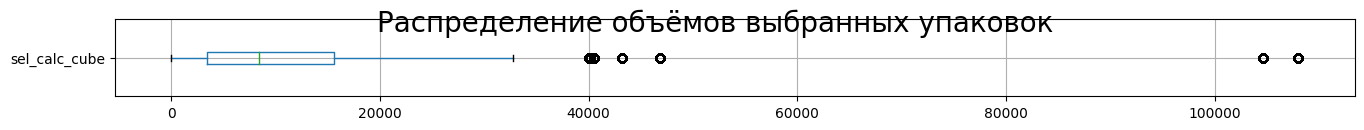

In [32]:
df.boxplot(['sel_calc_cube'], figsize = (16,1), vert=False) 
plt.suptitle('Распределение объёмов выбранных упаковок', size = 20)

Text(0.5, 0.98, 'Распределение объёмов выбранных упаковок')

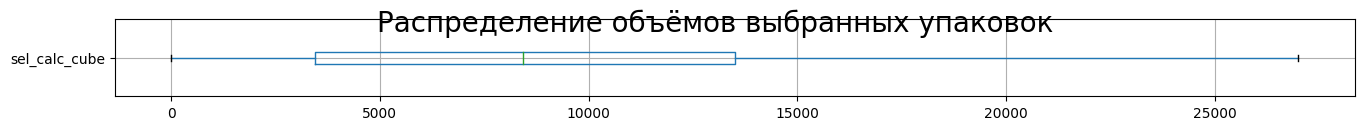

In [33]:
df[df['sel_calc_cube']<32000].boxplot(['sel_calc_cube'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение объёмов выбранных упаковок', size = 20)

В распределении объёмов выбранных упаковок выбросами являются все значения больше 32000

Text(0.5, 0.98, 'Распределение рассчитанных объёмов упакованных товаров')

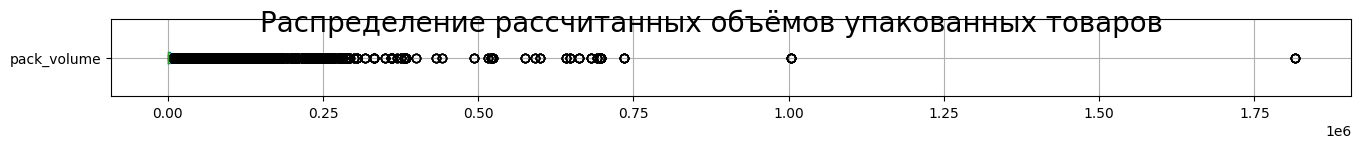

In [34]:
df.boxplot(['pack_volume'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение рассчитанных объёмов упакованных товаров', size = 20)

array([[<Axes: title={'center': 'pack_volume'}>]], dtype=object)

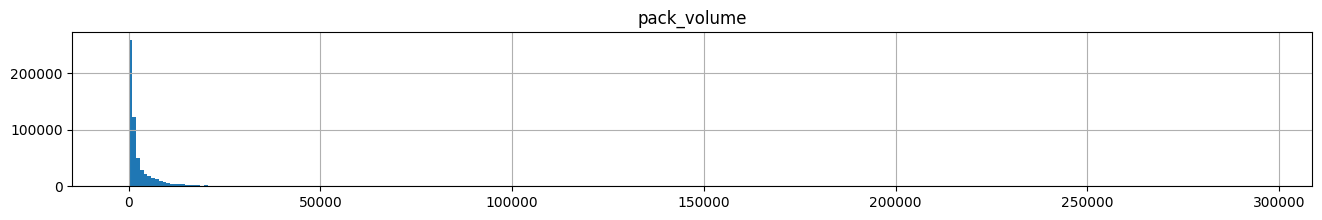

In [45]:
df[df['pack_volume']<300000].hist('pack_volume', bins =300, figsize = (16,2))

In [36]:
len(df[df['pack_volume']>300000])/len(df)*100

0.039441692031946106

В распределении рассчитанных объёмов упакованных товаров выбросы - все значения больше 300000. Это всего 0.04% 

Text(0.5, 0.98, 'Распределение размера a')

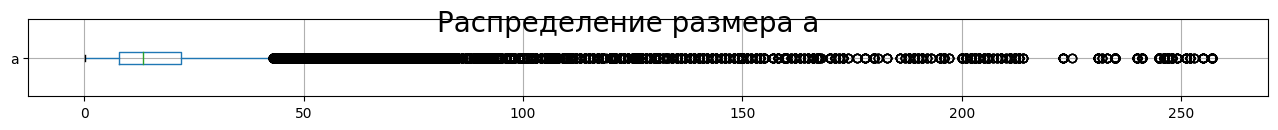

In [39]:
df.boxplot(['a'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера a', size = 20)

array([[<Axes: title={'center': 'a'}>]], dtype=object)

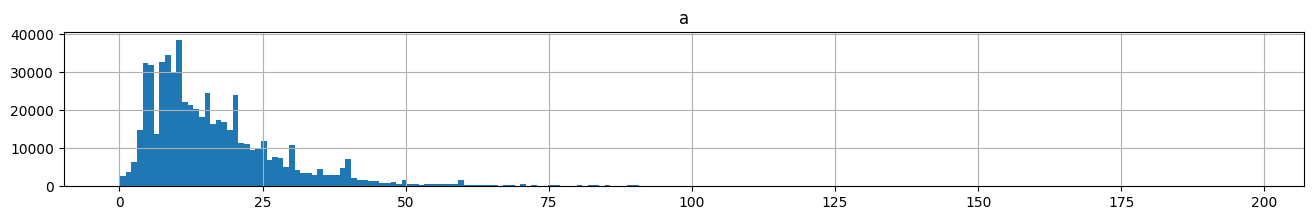

In [48]:
df[df['a']<200].hist('a', bins =200, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера a')

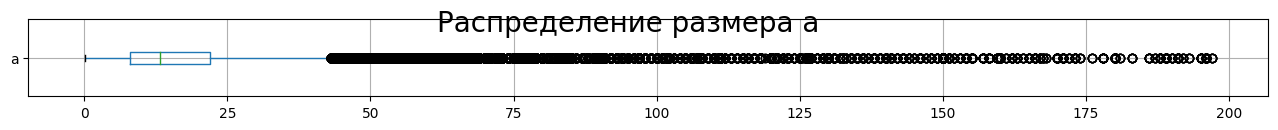

In [49]:
df[df['a']<200].boxplot(['a'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера a', size = 20)

In [50]:
len(df[df['a']>200])/len(df)*100

0.1534398314491743

В распределении размерак 'a' выбросы - все значения больше 90. Это всего 0.15%

Text(0.5, 0.98, 'Распределение размера b')

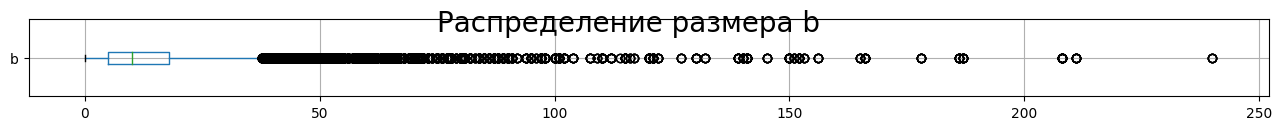

In [51]:
df.boxplot(['b'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера b', size = 20)

array([[<Axes: title={'center': 'b'}>]], dtype=object)

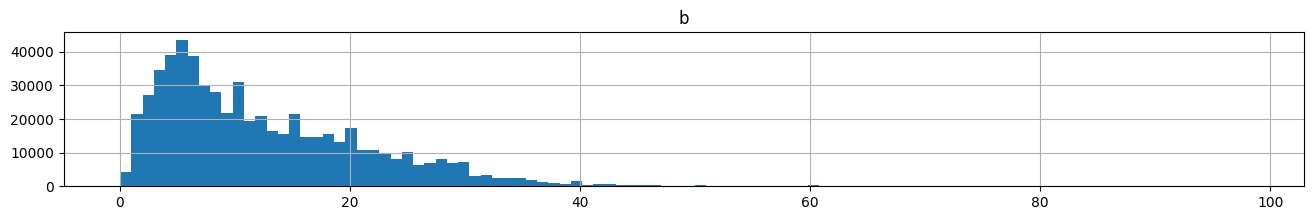

In [55]:
df[df['b']<100].hist('b', bins =100, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера b')

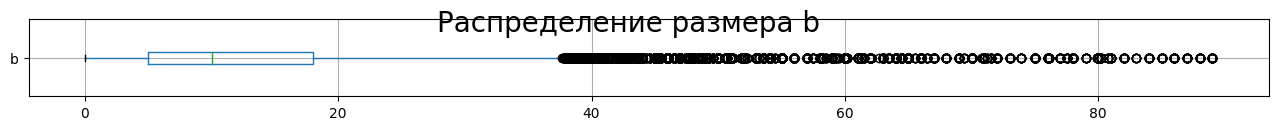

In [56]:
df[df['b']<90].boxplot(['b'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера b', size = 20)

In [57]:
len(df[df['b']>90])/len(df)*100

0.08104685240319727

В распределении размерак 'b' выбросы - все значения больше 90. Это всего 0.08% 

Text(0.5, 0.98, 'Распределение размера c')

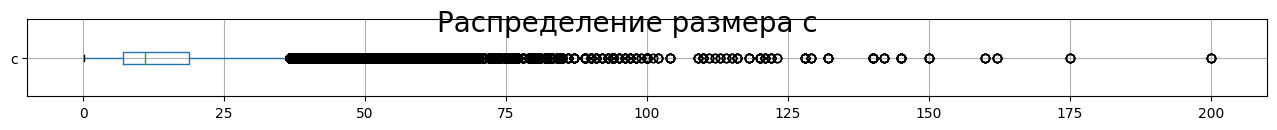

In [58]:
df.boxplot(['c'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера c', size = 20)

array([[<Axes: title={'center': 'c'}>]], dtype=object)

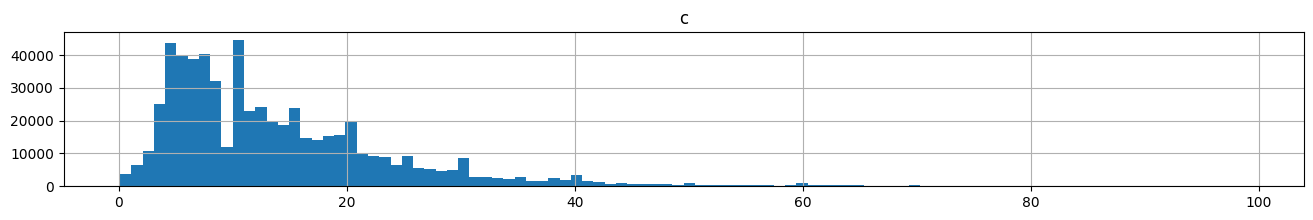

In [61]:
df[df['c']<100].hist('c', bins =100, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера c')

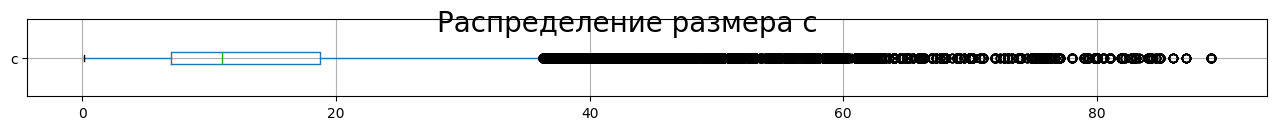

In [63]:
df[df['c']<90].boxplot(['c'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера c', size = 20)

In [64]:
len(df[df['c']>90])/len(df)*100

0.071061613914097

В распределении размерак 'c' выбросы - все значения больше 90. Это всего 0.07% 

**************

**Вывод:**

1. 4 датасета объеденены в один

2. Удалены пропуски 1.6% данных
Удалены дубликаты, 58,4% нового после объединения датасета. Большое количесво объясняется добавлением строк во время объединения 

3. Распределения значений в основном имеют положительную ассиметрию - длинный хвост справа. Небольшие значения, например длина упаковки, преобладают и их количество уменьшается с ростом значений.

4. Обнаруженные выбросы удалим в следующум разделе предобработки.


**************

## Предобработка данных

#### Удаление выбросов

In [68]:
df = df.query('sel_calc_cube < 32000')
df = df.query('pack_volume < 300000')
df = df.query('a < 200')
df = df.query('b < 200')
df = df.query('c < 200')

In [72]:
(600887 - len(df))/600887*100

4.309462511254196

In [73]:
df.reset_index(drop= True , inplace= True )

Выбросы 4,31% удалены

Учитывая информацию в описании данных "DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей)" - удаляем признак

In [74]:
df_carton.drop(['DISPLAYRFPACK'], axis= 1 , inplace= True)

In [75]:
df_carton.head()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT
0,YMA,24.70,15.00,10.00
1,YMC,30.00,20.00,15.00
2,YME,30.00,30.00,44.50
3,YMF,35.00,25.00,15.00
4,YMG,44.70,30.00,20.00


In [76]:
df_carton.shape

(29, 4)

#### Кореляция

In [77]:
display(df.corr().style.background_gradient(cmap='summer'))

,box_num,sel_calc_cube,pack_volume,goods_wght,a,b,c,cargotype
box_num,1.000000,-0.055856,0.013733,0.005242,0.024547,0.009149,0.054268,-0.006685
sel_calc_cube,-0.055856,1.000000,-0.130358,-0.137325,-0.067736,0.000361,-0.041711,0.032806
pack_volume,0.013733,-0.130358,1.000000,0.708932,0.531610,0.419851,0.529737,-0.032250
goods_wght,0.005242,-0.137325,0.708932,1.000000,0.501092,0.389567,0.481521,-0.038921
a,0.024547,-0.067736,0.531610,0.501092,1.000000,0.010759,0.532164,-0.021329
b,0.009149,0.000361,0.419851,0.389567,0.010759,1.000000,0.015937,-0.038469
c,0.054268,-0.041711,0.529737,0.481521,0.532164,0.015937,1.000000,0.006737
cargotype,-0.006685,0.032806,-0.032250,-0.038921,-0.021329,-0.038469,0.006737,1.000000


Проверка корреляции показала отсутствие слишком высокой линейной зависимости между признаками, кроме goods_wght и pack_volume. Здесь прямая линейная зависимость 0.7. Пока признаки оставим

**************

#### Целевой признак

In [78]:
df

,selected_cartontype,box_num,sel_calc_cube,pack_volume,goods_wght,a,b,c,cargotype,description
0,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,290.00,Склад МГТ (малогабаритный товар)
1,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,600.00,"одежда, обувь, аксессуары"
2,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,610.00,обувь взрослая
3,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,950.00,пачкается
4,NONPACK,1,0,2046,0.10,11.00,6.00,31.00,970.00,впитывает запах
...,...,...,...,...,...,...,...,...,...,...
574987,NONPACK,4,0,1617,0.43,77.00,3.00,6.00,310.00,хрупкое
574988,NONPACK,2,0,16200,1.70,45.00,8.00,45.00,200.00,техника и электроника
574989,NONPACK,2,0,16200,1.70,45.00,8.00,45.00,291.00,Склад СГТ (среднегабаритный товар)
574990,NONPACK,2,0,16200,1.70,45.00,8.00,45.00,310.00,хрупкое


In [81]:
df[df['sel_calc_cube'] != 0]

,selected_cartontype,box_num,sel_calc_cube,pack_volume,goods_wght,a,b,c,cargotype,description
40,MYC,1,8436,3456,3.05,24.00,8.00,18.00,290.00,Склад МГТ (малогабаритный товар)
41,MYC,1,8436,3456,3.05,24.00,8.00,18.00,360.00,упаковка в пленку
42,MYC,1,8436,3456,3.05,24.00,8.00,18.00,440.00,косметика и парфюмерия
43,MYC,1,8436,3456,3.05,24.00,8.00,18.00,441.00,товары для красоты
44,MYC,1,8436,3456,3.05,24.00,8.00,18.00,460.00,пахучий
...,...,...,...,...,...,...,...,...,...,...
574970,YMA,1,3360,378,0.03,14.00,3.00,9.00,310.00,хрупкое
574971,YMA,1,3360,160,0.03,10.00,4.00,4.00,200.00,техника и электроника
574972,YMA,1,3360,160,0.03,10.00,4.00,4.00,290.00,Склад МГТ (малогабаритный товар)
574973,YMA,1,3360,160,0.03,10.00,4.00,4.00,310.00,хрупкое


#### Кодирование категориальных признаков

С целью исключения категориальных признаков для обучения модели преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE)

In [ ]:
df = pd.get_dummies (df, columns=['selected_cartontype', 'recommended_cartontype', 'cargotype', 'description'], drop_first= True)

In [ ]:
df.head()

**************

#### Разделение данных на обучающую 75% и тестовую выборку 25%

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=42)  

Проверка размера выборок

In [ ]:
len(df) - len(train) - len(test)

**************

#### Масштабирование признаков

Приведение непрерывных значений признаков к единому масштабу.

Для выборки train применяется метод fit и transform совместно - fit_transform, а для выборки test - transform

In [ ]:
numeric = ['box_num', 'sel_calc_cube', 'pack_volume', 'rec_calc_cube', 'goods_wght', 'a', 'b', 'c']

In [ ]:
scaler = StandardScaler()

In [ ]:
train[numeric] = scaler.fit_transform(train[numeric])

In [ ]:
test[numeric] = scaler.transform(test[numeric])

In [ ]:
train

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,selected_cartontype_MYB,selected_cartontype_MYC,selected_cartontype_MYD,selected_cartontype_MYE,selected_cartontype_MYF,selected_cartontype_NONPACK,selected_cartontype_STRETCH,selected_cartontype_YMA,selected_cartontype_YMC,selected_cartontype_YMF,selected_cartontype_YMG,selected_cartontype_YMW,recommended_cartontype_MYB,recommended_cartontype_MYC,recommended_cartontype_MYD,recommended_cartontype_MYE,recommended_cartontype_MYF,recommended_cartontype_NONPACK,recommended_cartontype_STRETCH,recommended_cartontype_YMA,recommended_cartontype_YMC,recommended_cartontype_YMF,recommended_cartontype_YMG,recommended_cartontype_YMT,recommended_cartontype_YMU,recommended_cartontype_YMV,recommended_cartontype_YMW,cargotype_20.0,cargotype_40.0,cargotype_81.0,cargotype_110.0,cargotype_120.0,cargotype_130.0,cargotype_140.0,cargotype_160.0,cargotype_200.0,cargotype_210.0,cargotype_290.0,cargotype_291.0,cargotype_292.0,cargotype_300.0,cargotype_301.0,cargotype_302.0,cargotype_303.0,cargotype_305.0,cargotype_310.0,cargotype_315.0,cargotype_320.0,cargotype_330.0,cargotype_340.0,cargotype_350.0,cargotype_360.0,cargotype_400.0,cargotype_410.0,cargotype_440.0,cargotype_441.0,cargotype_460.0,cargotype_480.0,cargotype_485.0,cargotype_490.0,cargotype_510.0,cargotype_520.0,cargotype_600.0,cargotype_601.0,cargotype_610.0,cargotype_611.0,cargotype_620.0,cargotype_621.0,cargotype_622.0,cargotype_623.0,cargotype_640.0,cargotype_641.0,cargotype_670.0,cargotype_671.0,cargotype_672.0,cargotype_673.0,cargotype_690.0,cargotype_691.0,cargotype_692.0,cargotype_710.0,cargotype_720.0,cargotype_750.0,cargotype_751.0,cargotype_770.0,cargotype_780.0,cargotype_790.0,cargotype_799.0,cargotype_801.0,cargotype_900.0,cargotype_901.0,cargotype_905.0,cargotype_908.0,cargotype_910.0,cargotype_920.0,cargotype_931.0,cargotype_950.0,cargotype_955.0,cargotype_960.0,cargotype_970.0,cargotype_980.0,cargotype_990.0,cargotype_1010.0,cargotype_1300.0,description_Нельзя на ФФЦ и СЦ,description_Потребует обязательной маркировки в ближайшем будущем,description_Склад КГТ (крупногабаритный товар),description_Склад МГТ (малогабаритный товар),description_Склад СГТ (среднегабаритный товар),description_Терморежим 13-22,description_Требует обязательной маркировки,description_агрохимикаты,"description_аксессуары, часы и украшения",description_аптека,description_большой аксессуар,description_бытовая техника,description_бытовая химия,description_в ассортименте,description_ветеринарная аптека,description_возможно вскрытие заводской упаковки покупателем,description_возрастное ограничение на получение товара,description_впитывает запах,description_готовое блюда,description_детские игрушки и игры,description_жидкость,description_интим товар,description_керамика/стекло/камень/фарфор,description_консервы,description_корма для животных,description_косметика и парфюмерия,description_мебель,description_медикаменты,description_меркурий,description_мнется,description_многоместный товар,description_не определен,description_не требует упаковки,description_нельзя примерить,description_обувь взрослая,description_обувь детская,description_одежда верхняя,description_одежда детская,description_одежда прочая,description_одежда с плечиками,"description_одежда, обувь, аксессуары",description_опасный,description_опасный Авиа,description_охлажденные,description_пахучий,description_пачкает,description_пачкается,description_пестициды,description_полуфабрикат,description_продукты питания,description_ручки письменные,description_семена,description_средства личной гигиены,description_строительные материалы,description_сухие,description_сыпучее,description_сырье,description_техника и электроника,description_товары для авто и мототехники,description_товары для животных,description_товары для красоты,description_товары для спорта и отдыха,description_требует доставки с термо режимом 0+,description_тяжеловесный и крупногабаритный,description_тяжеловесный и крупногаб

Обучающие признаки

In [ ]:
x_train = train.drop(['client_off'] , axis=1)

Обучающие целевые признаки

In [ ]:
y_train = train['client_off']

Тестовые признаки

In [ ]:
x_test = test.drop(['client_off'] , axis=1)

Тестовый целевой признак

In [ ]:
y_test = test['client_off']

**************

# Обучение моделей

Выбор таргета основан на ошибках предыдущих рекомендаций, совпадения рекомендаций и авбора оставлены. Несовпадения - оставлен "выбор"

In [ ]:
(df_data[df_data['sel_calc_cube'] == df_data['rec_calc_cube']])['rec_calc_cube'].count()

Обучать будем три модели:
1. Определение размера упаковки
2. Определение типа упаковки
3. Определение совместимости товаров

## 1. Определение размера упаковки

Для обучения модели оставим только те признаки, которые отвечают за размер

In [ ]:
df.head(50)

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,selected_cartontype_MYB,selected_cartontype_MYC,...,description_упаковка в пленку,description_фреш,description_химикаты,description_хрупкое,description_цена высокая,description_цена низкая,description_цена средняя,description_ценное,description_цифровой товар,description_электроника
0,1,0,3050,15579,0.90,18.60,3.30,49.70,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,3050,15579,0.90,18.60,3.30,49.70,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3050,15579,0.90,18.60,3.30,49.70,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,13662,26820,4.40,30.00,23.00,22.00,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,13662,26820,4.40,30.00,23.00,22.00,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,13662,26820,4.40,30.00,23.00,22.00,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,4518,26277,0.70,14.00,10.70,43.80,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,4518,26277,0.70,14.00,10.70,43.80,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,6346,13125,2.08,23.40,8.00,33.90,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,6346,13125,2.08,23.40,8.00,33.90,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_size = [['sel_calc_cube', 'pack_volume', 'rec_calc_cube']]

Index(['box_num', 'sel_calc_cube', 'pack_volume', 'rec_calc_cube',
       'goods_wght', 'a', 'b', 'c', 'selected_cartontype_MYB',
       'selected_cartontype_MYC',
       ...
       'description_упаковка в пленку', 'description_фреш',
       'description_химикаты', 'description_хрупкое',
       'description_цена высокая', 'description_цена низкая',
       'description_цена средняя', 'description_ценное',
       'description_цифровой товар', 'description_электроника'],
      dtype='object', length=187)

In [ ]:
df.drop(['Unnamed: 0_x', 'whs', 'orderkey', 'selected_carton', 'recommended_carton', 'who', 
'trackingid', 'sku', 'Unnamed: 0_y', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis= 1 , inplace= True)

0             0
291700        0
291692        0
291691        0
291690        0
          ...  
432185    27000
432184    27000
432183    27000
432181    27000
407507    27000
Name: sel_calc_cube, Length: 624962, dtype: int64